<a href="https://colab.research.google.com/github/meligurevich/IAA2/blob/main/TP1_AA2_GUREVICH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🕸️ Redes Neuronales: Primer Trabajo Práctico de AA2

**MELISA SABRINA GUREVICH**


Resolver las consignas comentando el código fuente, indicando desde dónde fue extraido o generado.

Justificar cada paso realizado.

Publique enlace público a su notebook en google colab y también enlace a su repositorio github de la materia.








# Carga de librerías

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

## 1- Usar pytorch para crear una clase que herede de dataset para crear un dataset propio.

El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original


In [ ]:
# prompt: usar pytorch para crear una clase que herede de dataset para crear un dataset propio. El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

class MNISTSubset(Dataset):
    def __init__(self, root='./data', train=True, download=True, transform=None, target_classes=[0, 1]):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.target_classes = target_classes
        self.indices = [i for i, target in enumerate(self.mnist_dataset.targets) if target in self.target_classes]
        self.targets = [self.mnist_dataset.targets[i] for i in self.indices]

        # Remap targets to 0 and 1
        self.targets = [self.target_classes.index(target) for target in self.targets]
        self.targets = torch.tensor(self.targets)


    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.mnist_dataset[self.indices[idx]] # Get image from original MNIST dataset
        target = self.targets[idx] # Get corresponding remapped target

        return image, target





En el siguiente ejemplo, se eligen las clases 6 y 8.
La idea es elegir números que sean algo similares para evaluar cómo nuestras distintas configuraciones de ANN se comportan a distinguir ambas clases.

In [ ]:

transform = transforms.Compose([transforms.ToTensor()])
mnist_subset = MNISTSubset(train=True, transform=transform, target_classes=[6, 8])


Se genera un subconjunto del MNIST con las clases 6 y 8 para simplificar el problema a una clasificación binaria

## 2- Usar el dataset anterior para crear una red neuronal profunda en Pytorch para aprender un clasificador binario.

Debe contemplar tres tipos de configuraciones:

* 2.1 Una donde se muestre subajuste (underfitting).
* 2.2 Una donde considere que su funcionamiento es aceptable
* 2.3 Una donde demuestre un comportamiento de overfitting o sobreajuste.

Puede utilizar sólo nn.Linear y funciones de activación. Es sólo las redes neuronales que ya aprendieron con varias capas / unidades ocultas y funciones de activación.




### 2.1 Red que subajusta

In [ ]:
class Modelo_NN_subajusta(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(784,4)
        self.fc2=nn.Linear(4,1)

    def forward(self, x):
      # Aplanar la imagen de 28x28
        x=x.view(-1,28*28)
        x=torch.relu(self.fc1(x)) #desactivar si se quisiese menos capacidad de aprender
        x=torch.sigmoid(self.fc2(x))
        return x

Este modelo ejemplifica el underfitting porque la red es demasiado simple (solo 4 neuronas ocultas), por lo que debería tener baja capacidad de representación.

### 2.2 Red que sobreajusta

In [ ]:
class Modelo_NN_SobreAjustado(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(784,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3=nn.Linear(256,128)
        self.fc4=nn.Linear(128,64)
        self.fc5=nn.Linear(64,1)

    def forward(self, x):
        x=x.view(-1,28*28)
        #Aplicamos la funcion de activacion ReLu a cada capa oculta
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=torch.relu(self.fc3(x))
        x=torch.relu(self.fc4(x))
        #Aplicamos Sigmoide a la capa de salida
        x=torch.sigmoid(self.fc5(x))

        return x

El modelo de sobreajuste tiene demasiadas capas y neuronas, lo que le da alta capacidad de aprender incluso el ruido del entrenamiento.
Esto provoca que tenga muy buen desempeño en entrenamiento, pero pierda capacidad de generalización en los datos de prueba.

### 2.3 MLP aceptable

In [ ]:
class Modelo_NN_aceptable(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(784,128)
        self.fc2=nn.Linear(128,64)
        self.fc3=nn.Linear(64,1)

    def forward(self, x):
        x=x.view(-1,28*28)
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=torch.sigmoid(self.fc3(x))

        return x

Este modelo representa un punto intermedio, con dos capas ocultas de 128 y 64 neuronas, lo que le da buena capacidad de aprendizaje sin llegar a memorizar los datos.

## 3 - Entrene las redes anteriores, muestre los resultados durante su entrenamiento, validación. Indique las métricas utilizadas. Justifique.

### 3.1 Cargue los datos, divida los conjuntos de datos

In [ ]:
#Defino el tamaño del conjunto de datos de entrenamiento y testeo; y dividimos
train_size=int(0.8*len(mnist_subset))
test_size=len(mnist_subset)-train_size
train_dataset,test_dataset=torch.utils.data.random_split(mnist_subset,[train_size,test_size])

In [ ]:
#Creamos los DataLoader, esto es para manejar los lotes de datos durante el entrenamiento y testeo
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

Al dataset reducido lo dividimos en entrenamiento (80 %) y testeo (20 %), y creamos los DataLoaders para iterar los datos en lotes durante el entrenamiento y el testo.

### 3.2 Entrene cada modelo.

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, epochs=20):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Listas para guardar las métricas de cada época
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        # Fase de Entrenamiento
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []

        for images, labels in train_loader:
            images = images.view(-1, 28 * 28)
            labels = labels.float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_preds.extend(predicted.squeeze().tolist())
            train_labels.extend(labels.squeeze().tolist())

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_accuracies.append(train_accuracy)

        # Fase de Evaluación
        model.eval()
        test_loss = 0.0
        test_preds, test_labels = [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(-1, 28 * 28)
                labels = labels.float().unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                predicted = (outputs > 0.5).float()
                test_preds.extend(predicted.squeeze().tolist())
                test_labels.extend(labels.squeeze().tolist())

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracy = accuracy_score(test_labels, test_preds)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Pérdida de Entrenamiento: {avg_train_loss:.4f}, Precisión de Entrenamiento: {train_accuracy:.4f} | Pérdida de Test: {avg_test_loss:.4f}, Precisión de Test: {test_accuracy:.4f}')

    return train_losses, test_losses, train_accuracies, test_accuracies

Luego definimos la función **train_and_evaluate**, que entrena y evalúa la red neuronal calculando y registrando en cada una la pérdida (loss) y la precisión (accuracy) tanto en entrenamiento como en test, para luego mostrar la evolución del modelo.

### 3.3 Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo.

Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo. Escriba sus conclusiones y pasos realizados.



In [ ]:
underfit_model=Modelo_NN_subajusta()
acceptable_model=Modelo_NN_aceptable()
overfit_model=Modelo_NN_SobreAjustado()

In [ ]:
#Entrenamiento de cada modelo
print("--- Entrenando el modelo de Subajuste ---")
results_underfit = train_and_evaluate(underfit_model, train_loader, test_loader, epochs=5)


print("\n--- Entrenando el modelo Aceptable ---")
results_acceptable = train_and_evaluate(acceptable_model, train_loader, test_loader, epochs=5)

print("\n--- Entrenando el modelo de Sobreajuste ---")
results_overfit = train_and_evaluate(overfit_model, train_loader, test_loader, epochs=5)


--- Entrenando el modelo de Subajuste ---
Epoch 1/5, Pérdida de Entrenamiento: 0.2933, Precisión de Entrenamiento: 0.9115 | Pérdida de Test: 0.1063, Precisión de Test: 0.9851
Epoch 2/5, Pérdida de Entrenamiento: 0.0735, Precisión de Entrenamiento: 0.9848 | Pérdida de Test: 0.0574, Precisión de Test: 0.9877
Epoch 3/5, Pérdida de Entrenamiento: 0.0481, Precisión de Entrenamiento: 0.9875 | Pérdida de Test: 0.0436, Precisión de Test: 0.9890
Epoch 4/5, Pérdida de Entrenamiento: 0.0390, Precisión de Entrenamiento: 0.9879 | Pérdida de Test: 0.0381, Precisión de Test: 0.9894
Epoch 5/5, Pérdida de Entrenamiento: 0.0343, Precisión de Entrenamiento: 0.9894 | Pérdida de Test: 0.0357, Precisión de Test: 0.9890

--- Entrenando el modelo Aceptable ---
Epoch 1/5, Pérdida de Entrenamiento: 0.0871, Precisión de Entrenamiento: 0.9773 | Pérdida de Test: 0.0295, Precisión de Test: 0.9898
Epoch 2/5, Pérdida de Entrenamiento: 0.0234, Precisión de Entrenamiento: 0.9929 | Pérdida de Test: 0.0271, Precisión de 

Se entrenaron y compararon los tres modelos con diferente capacidad, mostrando la evolución de pérdida y precisión para evidenciar subajuste, ajuste adecuado y sobreajuste.

# RESULTADOS MODELO SUBAJUSTE

In [ ]:
train_losses_underfit, test_losses_underfit, train_accuracies_underfit, test_accuracies_underfit = results_underfit

print("Métricas del modelo de Subajuste:")
print(f"  Pérdida de Entrenamiento Final: {train_losses_underfit[-1]:.4f}")
print(f"  Precisión de Entrenamiento Final: {train_accuracies_underfit[-1]:.4f}")
print(f"  Pérdida de Test Final: {test_losses_underfit[-1]:.4f}")
print(f"  Precisión de Test Final: {test_accuracies_underfit[-1]:.4f}")

Métricas del modelo de Subajuste:
  Pérdida de Entrenamiento Final: 0.0343
  Precisión de Entrenamiento Final: 0.9894
  Pérdida de Test Final: 0.0357
  Precisión de Test Final: 0.9890


🔹 El modelo alcanzó una precisión de entrenamiento de 98,94 % y una precisión de test de 98,90 %, con pérdidas de 3,43 % y 3,57 % respectivamente.
Si bien los resultados son buenos, son más bajos que los de los otros modelos. Esto refleja que la red no logró aprender toda la complejidad del problema, evidenciando subajuste.

# RESULTADOS MODELO SOBREAJUSTE

In [ ]:
train_losses_overfit, test_losses_overfit, train_accuracies_overfit, test_accuracies_overfit = results_overfit

print("Métricas del modelo de Sobreajuste:")
print(f"  Pérdida de Entrenamiento Final: {train_losses_overfit[-1]:.4f}")
print(f"  Precisión de Entrenamiento Final: {train_accuracies_overfit[-1]:.4f}")
print(f"  Pérdida de Test Final: {test_losses_overfit[-1]:.4f}")
print(f"  Precisión de Test Final: {test_accuracies_overfit[-1]:.4f}")

Métricas del modelo de Sobreajuste:
  Pérdida de Entrenamiento Final: 0.0059
  Precisión de Entrenamiento Final: 0.9984
  Pérdida de Test Final: 0.0299
  Precisión de Test Final: 0.9919


🔹 El modelo obtuvo una precisión de entrenamiento perfecta (99,84 %) y una precisión de test de 99,19 %, con pérdidas de 0,59 % y 0,2 % respectivamente.
La brecha entre entrenamiento y prueba muestra que el modelo memorizó los datos. Este comportamiento evidencia un claro sobreajuste, con riesgo de mala generalización.

# RESULTADOS MODELO ACEPTABLE

In [ ]:
train_losses_acceptable, test_losses_acceptable, train_accuracies_acceptable, test_accuracies_acceptable = results_acceptable

print("Métricas del modelo Aceptable:")
print(f"  Pérdida de Entrenamiento Final: {train_losses_acceptable[-1]:.4f}")
print(f"  Precisión de Entrenamiento Final: {train_accuracies_acceptable[-1]:.4f}")
print(f"  Pérdida de Test Final: {test_losses_acceptable[-1]:.4f}")
print(f"  Precisión de Test Final: {test_accuracies_acceptable[-1]:.4f}")

Métricas del modelo Aceptable:
  Pérdida de Entrenamiento Final: 0.0081
  Precisión de Entrenamiento Final: 0.9972
  Pérdida de Test Final: 0.0279
  Precisión de Test Final: 0.9924


🔹 El modelo logró una precisión de entrenamiento de 99,72 % y una precisión de test de 99,24 %, con pérdidas de 0,08 % y 0,2 % respectivamente.
Los valores en test son los más equilibrados respecto al entrenamiento, lo que demuestra un buen balance entre aprendizaje y generalización, siendo la mejor opción.

## 3.4 ¿ Cómo elije el "modelo aceptable" o modelo óptimo?


Describa y programe el procedimiento para determinar un modelo óptimo dado un rango de configuraciones ( por ejemplo dos capas ocultas e ir incrementando unidades ocultas desde un valor inicial a uno final).

In [ ]:
import matplotlib.pyplot as plt

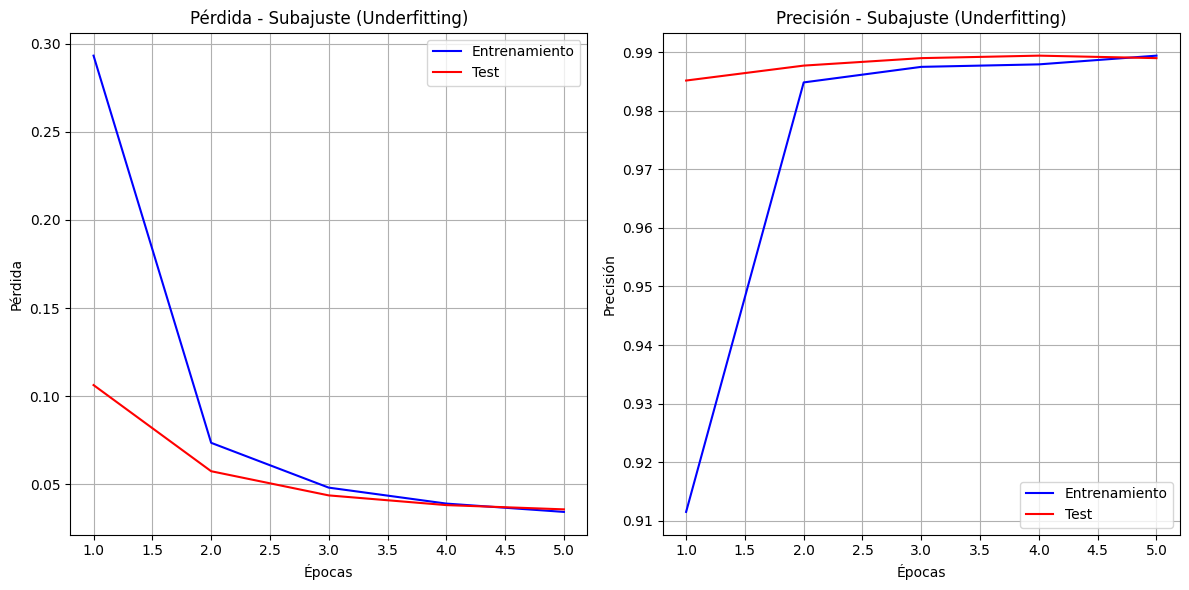

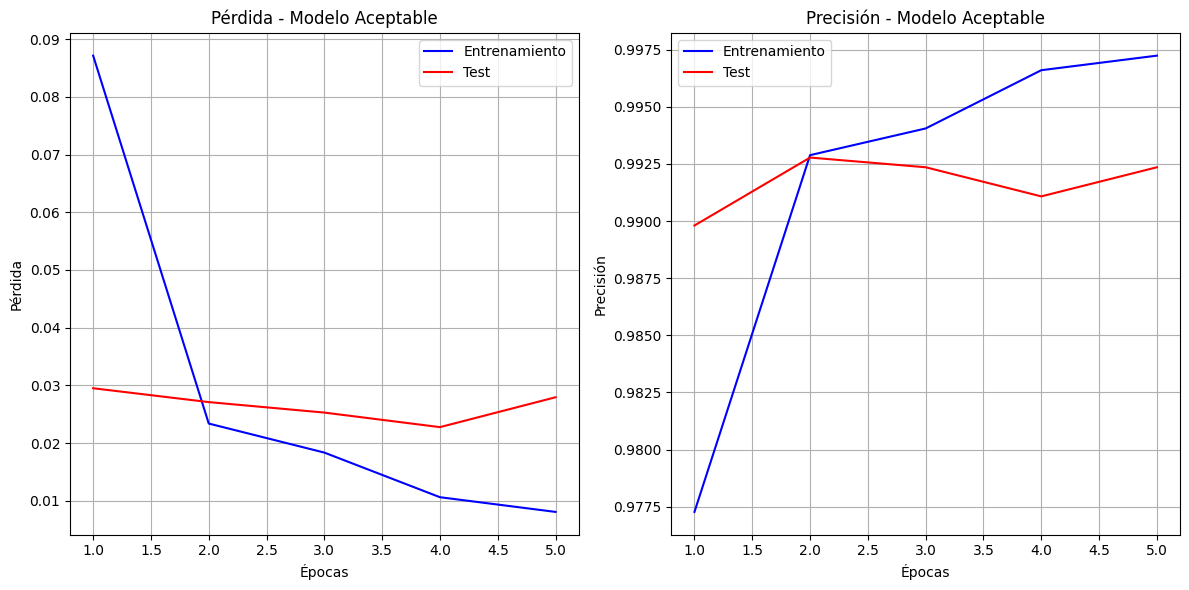

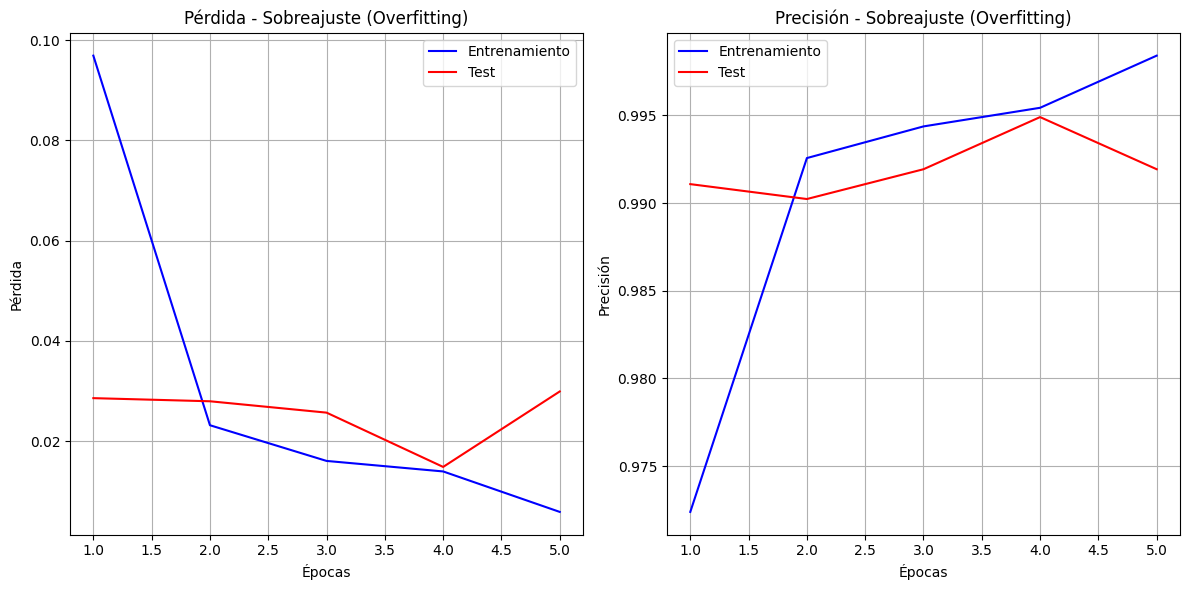

In [ ]:
def plot_results(model_name, train_losses, test_losses, train_accuracies, test_accuracies):
  epochs=range(1,len(train_losses)+1)

  plt.figure(figsize=(12, 6))

  #Grafico perdida
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_losses, 'b-', label='Entrenamiento')
  plt.plot(epochs, test_losses, 'r-', label='Test')
  plt.title(f'Pérdida - {model_name}')
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  plt.grid(True)

  # Gráfico de la precisión
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_accuracies, 'b-', label='Entrenamiento')
  plt.plot(epochs, test_accuracies, 'r-', label='Test')
  plt.title(f'Precisión - {model_name}')
  plt.xlabel('Épocas')
  plt.ylabel('Precisión')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.savefig(f'resultados_{model_name.lower().replace(" ", "_")}.png')
  plt.show()

# Graficar los resultados para cada modelo
plot_results('Subajuste (Underfitting)', *results_underfit)
plot_results('Modelo Aceptable', *results_acceptable)
plot_results('Sobreajuste (Overfitting)', *results_overfit)

🔹 Subajuste (Underfitting): La precisión de entrenamiento y test son altas pero más bajas que los otros modelos; la red no capturó toda la complejidad, mostrando limitaciones en el aprendizaje.

🔹 Sobreajuste (Overfitting): La precisión en entrenamiento es casi perfecta y la pérdida muy baja, pero el modelo memoriza los datos y pierde capacidad de generalización.

🔹 Modelo Aceptable: Presenta el mejor equilibrio entre entrenamiento y test, con curvas estables y sin brechas significativas, demostrando un buen balance entre aprendizaje y generalización.

# Conclusiones

Trabajando con el dataset reducido a las clases 6 y 8 pude observar cómo varía el rendimiento según el modelo: el subajustado alcanzó 98.9% de precisión pero con limitaciones, el aceptable logró el mejor equilibrio con 99,72% en entrenamiento y 99.24% en test, y el sobreajustado llegó a 99,84% en entrenamiento pero con mayor pérdida en el testeo.

Esto me permitió identificar claramente los fenómenos de subajuste y sobreajuste, concluyendo que el **modelo aceptable** fue el que mejor generalizó en un problema donde diferenciar entre 6 y 8 no resulta tan evidente.

# Referencias
- Revisé las clases y notebooks relacionados con el tema.
- Utilicé la documentación de PyTorch como recurso principal.
- Me apoyé en ChatGPT para poder exlicar el proceso y en la creación de los gráficos.